# **Starting point - Load training images from database**

Showing raw images


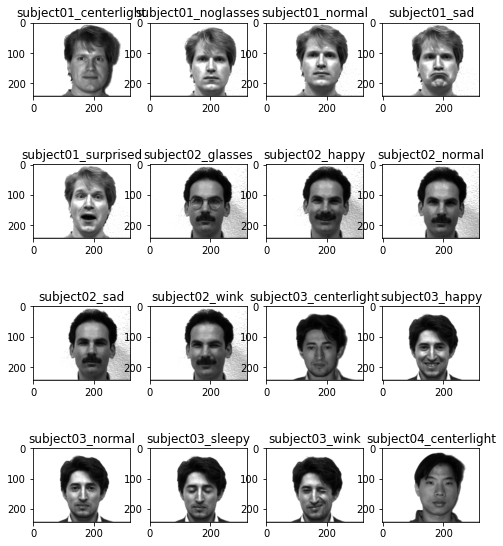

In [1]:
from numpy.core.defchararray import title
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


root_images_path = "."
images_path = root_images_path + "/FRWML_Project_Images/Training_Images/"
image_files = os.listdir(images_path)

max_image_per_person = 5
image_counter = {}

# Load training images
raw_training_images = []
raw_training_images_labels = []
for image_file in image_files:
    if '.jpg' in image_file or '.png' in image_file:
        if image_file.split('_')[0] not in image_counter or image_counter[image_file.split('_')[0]] < max_image_per_person:
            with Image.open(images_path + image_file) as image:
                raw_training_images.append(np.array(image.convert('L')))
                raw_training_images_labels.append(image_file)
        if image_file.split('_')[0] in image_counter:
            image_counter[image_file.split('_')[0]] += 1
        else:
            image_counter[image_file.split('_')[0]] = 1 

# Show the images before face detection
fig, axes = plt.subplots(4, 4, figsize=(8, 10))
for i in range(16):
    axes[i//4][i%4].imshow(raw_training_images[i], cmap="gray")
    axes[i//4][i%4].set_title(raw_training_images_labels[i].split(".")[0])
print("Showing raw images")
plt.show()


# **Detect face region from the face image using opencv**



Showing detected faces


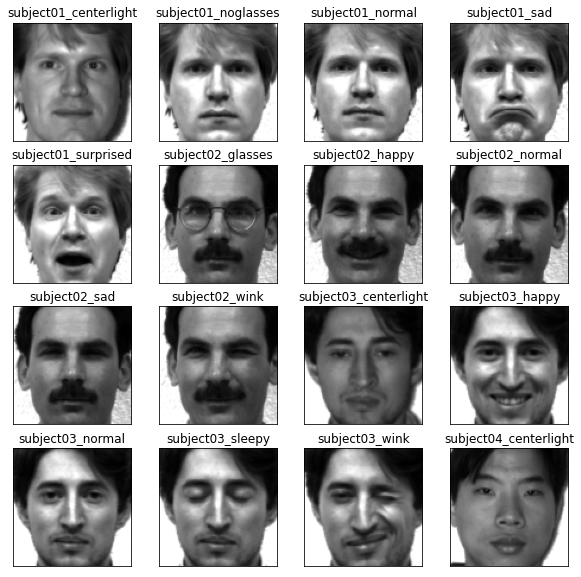

In [2]:
import imutils

detected_face_target_shape = (100, 100)

# Function used to detect faces in an images using opencv and haarcascade
def detect_faces(image):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    return face_cascade.detectMultiScale(image)


def detect_eyes(image):
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
    return eye_cascade.detectMultiScale(image, 1.1, 10)


def rotate_face(image):
    eyes = []
    backup_img = image.copy()
    image = imutils.resize(image,320)
    faces = detect_faces(image)
    if len(faces) == 0:
        return backup_img
    ex, ey, ew, eh = faces[0]
    roi_gray = image[ey:ey + eh, ex:ex + ew]
    eyes = detect_eyes(roi_gray)

    # Get the image width and height, then get center point
    h, w = image.shape[:2]
    imgCenter = (w // 2, h // 2)

    if len(eyes) == 2:
        # Determine left eye and right eye based on position of x-axis
        if eyes[0][0] < eyes[1][0]:
            left_eye = eyes[0]
            right_eye = eyes[1]
        else:
            left_eye = eyes[1]
            right_eye = eyes[0]
        # Find the center of eyes
        left_eye_center = (int(left_eye[0] + (left_eye[2] / 2)), int(left_eye[1] + (left_eye[3] / 2)))
        left_eye_x = left_eye_center[0]
        left_eye_y = left_eye_center[1]

        right_eye_center = (int(right_eye[0] + (right_eye[2] / 2)), int(right_eye[1] + (right_eye[3] / 2)))
        right_eye_x = right_eye_center[0]
        right_eye_y = right_eye_center[1]

        # To find the eye degree
        delta_x = right_eye_x - left_eye_x
        delta_y = right_eye_y - left_eye_y

        angle = np.arctan(delta_y / delta_x)
        angle = (angle * 180) / np.pi

        M = cv2.getRotationMatrix2D(imgCenter, angle, 1.0)
        rotated_image = cv2.warpAffine(image, M, (w, h))
    else:
        rotated_image = image

    return rotated_image

# Function to resize the detected face image to 100x100 to minimize distortion
def resize_face(face,rotated_img):
    x, y, w, h = face
    detected_face_region = rotated_img[int(y):int(y+h), int(x):int(x+w)]
    detected_face_region = cv2.resize(detected_face_region, detected_face_target_shape, interpolation=cv2.INTER_AREA)
    return detected_face_region

# Detect, resize, and store training face images
training_faces = []             # Store detected face image
training_faces_labels = []      # Store detected face image's label
original_image_shape = []
for label, image in zip(raw_training_images_labels, raw_training_images):
    # Rotate face
    rotated_img = rotate_face(image)
    
    # Detect faces
    faces = detect_faces(rotated_img)

    for face in faces:
        # Resize face
        resized_face = resize_face(face,rotated_img)

        # Store face only image and its associated label
        original_image_shape.append(rotated_img.shape)
        training_faces.append(resized_face.flatten())
        training_faces_labels.append(label)
        break
training_faces = np.array(training_faces)

# Show the captured face image after face detection
fig, axes = plt.subplots(4, 4, figsize=(10,10))
for i in range(16):
    axes[i//4][i%4].imshow(training_faces[i].reshape(detected_face_target_shape), cmap="gray")
    axes[i//4][i%4].set_title(training_faces_labels[i].split('.')[0])
    axes[i//4][i%4].get_xaxis().set_visible(False)
    axes[i//4][i%4].get_yaxis().set_visible(False)
print("Showing detected faces")
plt.show()

# **Apply PCA to get principle components as eigenfaces for face recognition**



The mean face = 


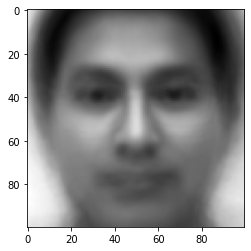

Showing the eigenfaces


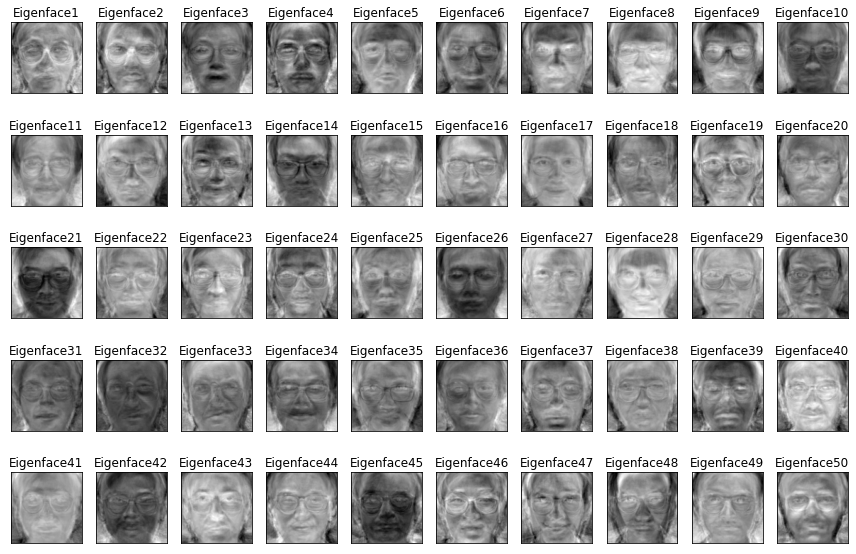

In [3]:
from sklearn.preprocessing import normalize
# Specify number of principle components to use for recognition
number_of_principle_components = 50

## Apply self implemented PCA to get principle components as eigenfaces (Custom PCA)
mean_face = np.mean(training_faces, axis=0)                                                         # Compute the mean of all faces
print("The mean face = ")
plt.imshow(mean_face.reshape(detected_face_target_shape),cmap="gray")
plt.show()
training_faces_adjusted =  training_faces - mean_face                                               # Mean adjust all faces
pca_cov = training_faces_adjusted @ training_faces_adjusted.T / training_faces_adjusted.shape[0]    # Compute the convariance matrix
eigenvalues, eigenfaces = np.linalg.eig(pca_cov)                                                    # Compute the eigenvalue and eigenvectors (eigenfaces)
sorted_index = np.argsort(eigenvalues)[::-1]                                                        # Get the sorting index of eigenvalues in descending order
eigenvalues = eigenvalues[sorted_index]                                                             # Sort the eigenvalues based on the sorted index
eigenfaces = eigenfaces[sorted_index] @ training_faces_adjusted                                     # Sort the eigenfaces based on the sorted index of eigenvalues
eigenfaces = normalize(eigenfaces, axis=1)                                                          # Normalize the eigenfaces
eigenfaces = eigenfaces[:number_of_principle_components]                                            # Take only first n number of eigenfaces as principle components

# Compute the weights of each image(adjusted) against each eigenfaces
face_weights = (training_faces - mean_face) @ eigenfaces.T

# Show the first 50 eigenfaces
fig, axes = plt.subplots(5, 10, figsize=(15, 10))
for i in range(50):
    axes[i//10][i%10].imshow(np.real(eigenfaces[i]).reshape(detected_face_target_shape), cmap="gray")
    axes[i//10][i%10].set_title("Eigenface" + str(i+1))
    axes[i//10][i%10].get_xaxis().set_visible(False)
    axes[i//10][i%10].get_yaxis().set_visible(False)
print("Showing the eigenfaces")
plt.show()

# **Plug in testing images to observe the recognition result and calculate the accuracy**

The PCA got 28 / 35 correct, and the accuracy is 80.00%


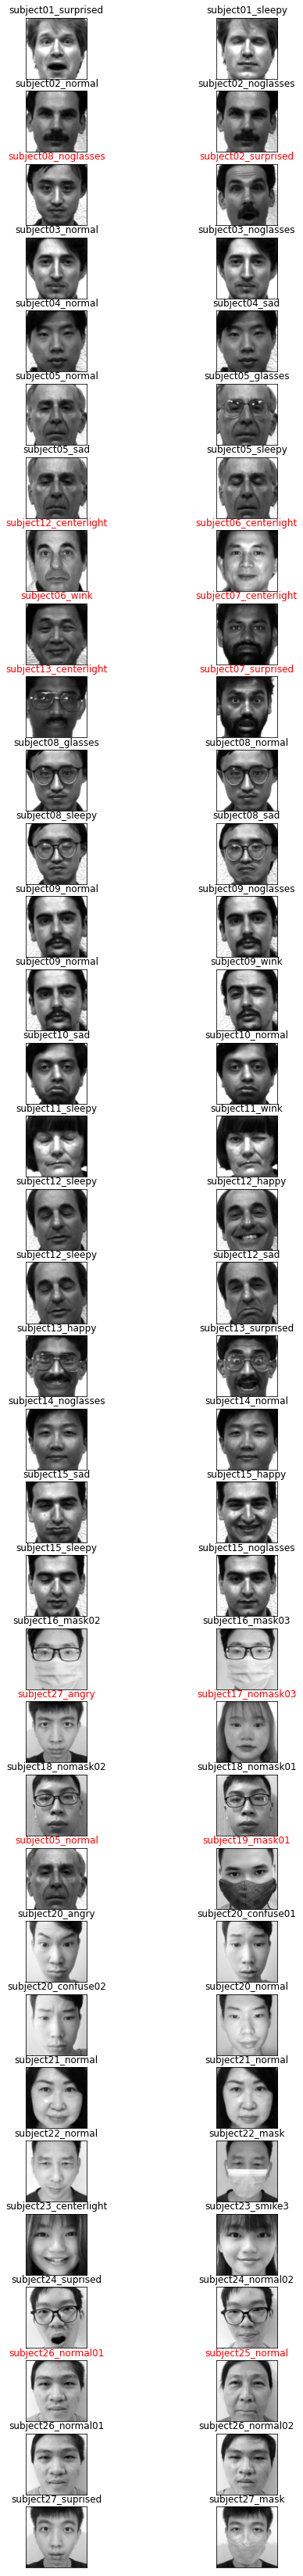

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

   subject01       1.00      1.00      1.00         1
   subject02       1.00      0.50      0.67         2
   subject03       1.00      1.00      1.00         1
   subject04       1.00      1.00      1.00         1
   subject05       0.67      1.00      0.80         2
   subject06       0.00      0.00      0.00         1
   subject07       0.00      0.00      0.00         2
   subject08       0.67      1.00      0.80         2
   subject09       1.00      1.00      1.00         2
   subject10       1.00      1.00      1.00         1
   subject11       1.00      1.00      1.00         1
   subject12       0.67      1.00      0.80         2
   subject13       0.50      1.00      0.67         1
   subject14       1.00      1.00      1.00         1
   subject15       1.00      1.00      1.00         2
   subject16       1.00      1.00      1.00         1
   subject17       0.00      0.00      0.00         1
   subject18       1.00    

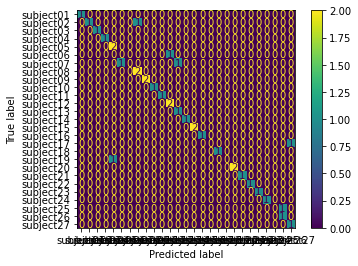

In [4]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

images_path = root_images_path + "/FRWML_Project_Images/Testing_Images/"
image_files = os.listdir(images_path)

# Load testing images
raw_testing_images = []
raw_testing_images_labels = []
for image_file in image_files:
    if '.jpg' in image_file or '.png' in image_file:
        with Image.open(images_path + image_file) as image:
            raw_testing_images.append(np.array(image.convert('L')))
            raw_testing_images_labels.append(image_file)

# Detect, resize, and store testing face images
testing_faces = []
testing_faces_labels = []
for label, image in zip(raw_testing_images_labels, raw_testing_images):
    # Rotate face
    rotated_img = rotate_face(image)
    
    # Detect faces
    faces = detect_faces(rotated_img)

    for face in faces:
        # Resize face
        resized_face = resize_face(face,rotated_img)

        # Store face only image and its associated label
        original_image_shape.append(image.shape)
        testing_faces.append(resized_face.flatten())
        testing_faces_labels.append(label)
        break
testing_faces = np.array(testing_faces)

# Multiply testing images(adjusted) with all eigenfaces to calculate the weight, and find the best match based on lowest distance, then calculate accuracy based on all testing images
correct_counter = 0
correct_label = []
predict_label = []
fig, axes = plt.subplots(testing_faces.shape[0], 2, figsize=(8,60))
for testing_index in range(testing_faces.shape[0]):
    correct_ans = False
    query = testing_faces[testing_index]
    query_weight = eigenfaces @ (query - mean_face).T
    euclidean_distance = np.linalg.norm(face_weights - query_weight, axis=1)
    best_match_index = np.argmin(euclidean_distance)
     
    if training_faces_labels[best_match_index].split('_')[0] == testing_faces_labels[testing_index].split('_')[0]:
        correct_counter += 1
        correct_ans = True

    correct_label.append(testing_faces_labels[testing_index].split('_')[0])
    predict_label.append(training_faces_labels[best_match_index].split('_')[0])

    axes[testing_index][0].imshow(training_faces[best_match_index].reshape(detected_face_target_shape), cmap="gray")
    axes[testing_index][0].set_title(training_faces_labels[best_match_index].split('.')[0], color='black' if correct_ans else 'red')
    axes[testing_index][0].get_xaxis().set_visible(False)
    axes[testing_index][0].get_yaxis().set_visible(False)    
    axes[testing_index][1].imshow(testing_faces[testing_index].reshape(detected_face_target_shape), cmap="gray")
    axes[testing_index][1].set_title(testing_faces_labels[testing_index].split('.')[0], color='black' if correct_ans else 'red')
    axes[testing_index][1].get_xaxis().set_visible(False)
    axes[testing_index][1].get_yaxis().set_visible(False)
print("The PCA got %d / %d correct, and the accuracy is %.2f%%" % (correct_counter, testing_faces.shape[0], correct_counter / testing_faces.shape[0] * 100))
plt.show()


ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(correct_label, predict_label, labels=np.unique(correct_label)), display_labels=np.unique(correct_label)).plot()
print(classification_report(correct_label, predict_label))


# **Performace comparison between PCA and Deep Learning CNN**

In [5]:
# Reshape training faces back into 2d matrix in order to fit into the CNN model later, and make the training face labels into categorical format
result_mapping = {}
mapping_counter = 0
training_faces = training_faces.reshape(training_faces.shape[0], 100, 100)
training_faces_labels_reformed = []
for label in training_faces_labels:
    if label.split('_')[0] not in result_mapping:
        result_mapping[label.split("_")[0]] = mapping_counter
        training_faces_labels_reformed.append(mapping_counter)
        mapping_counter += 1
    else:
        training_faces_labels_reformed.append(result_mapping[label.split("_")[0]])
training_faces_labels = training_faces_labels_reformed
training_faces_labels = np.array(training_faces_labels)

In [18]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense
 
# Create a Convolutional Neural Network (CNN) model using Keras
cnn = Sequential()
cnn.add(Convolution2D(16, kernel_size=(5, 5), strides=(1, 1), input_shape=(detected_face_target_shape[0], detected_face_target_shape[1], 1), activation='relu'))
cnn.add(MaxPool2D(pool_size=(2,2)))
cnn.add(Convolution2D(32, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
cnn.add(MaxPool2D(pool_size=(2,2)))
cnn.add(Convolution2D(64, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
cnn.add(MaxPool2D(pool_size=(2,2)))
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dense(mapping_counter, activation='softmax'))
cnn.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])

# Start training the CNN model using the training faces
cnn.fit(
    training_faces,
    training_faces_labels,
    batch_size=20,
    epochs=15)


Epoch 1/15
7/7 [==============================] - 1s 76ms/step - loss: 44.3408 - accuracy: 0.0246
Epoch 2/15
7/7 [==============================] - 1s 89ms/step - loss: 3.3159 - accuracy: 0.0738
Epoch 3/15
7/7 [==============================] - 0s 68ms/step - loss: 3.0784 - accuracy: 0.1557
Epoch 4/15
7/7 [==============================] - 0s 69ms/step - loss: 2.5975 - accuracy: 0.2951
Epoch 5/15
7/7 [==============================] - 1s 86ms/step - loss: 2.0360 - accuracy: 0.5246
Epoch 6/15
7/7 [==============================] - 0s 63ms/step - loss: 1.5915 - accuracy: 0.6066
Epoch 7/15
7/7 [==============================] - 0s 65ms/step - loss: 0.9769 - accuracy: 0.7459
Epoch 8/15
7/7 [==============================] - 0s 66ms/step - loss: 0.3618 - accuracy: 0.9016
Epoch 9/15
7/7 [==============================] - 1s 72ms/step - loss: 0.1520 - accuracy: 0.9754
Epoch 10/15
7/7 [==============================] - 0s 68ms/step - loss: 0.0796 - accuracy: 0.9836
Epoch 11/15
7/7 [===========

In [19]:
# Fit in the test faces into the CNN model and get the index of highest probability as prediction result
correct_counter = 0
for testing_index in range(testing_faces.shape[0]):
    correct_ans = False
    result = cnn.predict(testing_faces[testing_index].reshape(1, detected_face_target_shape[0], detected_face_target_shape[1]))
    best_match_index = np.argmax(result)
    if (testing_faces_labels[testing_index]).split('_')[0] in result_mapping.keys() and best_match_index == result_mapping[(testing_faces_labels[testing_index]).split('_')[0]]:
        correct_counter += 1
        correct_ans = True
print("The CNN got %d / %d correct, and the accuracy is %.2f%%" % (correct_counter, testing_faces.shape[0], correct_counter / testing_faces.shape[0] * 100))    

The CNN got 32 / 35 correct, and the accuracy is 91.43%
